In [251]:
import pandas as pd
import numpy as np
#import seaborn as sns
import math
import os
import datetime
import re
#from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
#drive.mount('/content/drive')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import tqdm
import scipy.stats as stats

In [323]:
freqs = pd.read_csv('./data/frequenciesExtra.csv')

In [324]:
numberRe = re.compile('[0-9]+')
noneRe = re.compile('None')
def daysStrToInt(dStr):
    if isinstance(dStr, str):
        if numberRe.match(dStr):
            return int(dStr.split(' ')[0])
        elif noneRe.match(dStr):
            return None
    return dStr

freqs['hospDistance'] = freqs['hospDistance'].transform(daysStrToInt)

In [325]:
def deIdCrf(crfs):
  return crfs.drop(columns=['Masked Client ID', 'Date of Review', 'Date'])

def deIdAdl(adls):
  return adls.drop(columns=['DeIdentify ID', 'CaregiverID', 'VisitDate', 'ActualTimeIn', 'ActualTimeOut', 'Date'])

In [326]:
freqs.columns

Index(['DeIdentify ID', 'CaregiverID', 'VisitDate', 'Date', 'ActualTimeIn',
       'ActualTimeOut', '0', '1', '2', '3',
       ...
       '466', '467', '468', '469', '470', '471', '472', '473',
       'hasHospitalization', 'hospDistance'],
      dtype='object', length=482)

In [330]:
x = deIdAdl(freqs).drop(columns=['hasHospitalization', 'hospDistance'])
y = freqs['hasHospitalization']
d = freqs['hospDistance']

In [331]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=15)

In [332]:
#model = SVC(kernel='poly', C=10, class_weight='balanced')
#model = SVC(kernel='poly', C=1, class_weight='balanced')
#model = SVC(kernel='linear', C=10, class_weight='balanced')
model = SVC(kernel='linear', C=1, class_weight='balanced')
#model = SVC(kernel='linear')
#model = DecisionTreeClassifier(criterion='entropy')
#model = KNeighborsClassifier(n_neighbors=5)
#model = BaggingClassifier(base_estimator=SVC(kernel='linear'), n_estimators=10, random_state=15)

model.fit(x_train, y_train)

SVC(C=1, class_weight='balanced', kernel='linear')

In [333]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

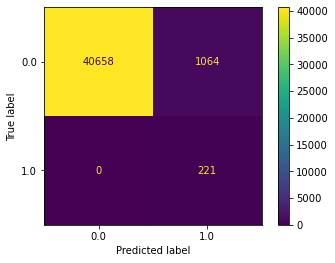

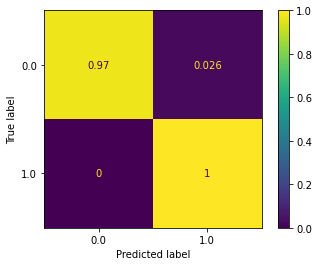

In [334]:
#Training results
conf = confusion_matrix(y_true=y_train, y_pred=pred_train)
plot_confusion_matrix(model, x_train, y_train)
plot_confusion_matrix(model, x_train, y_train, normalize='true')
print(classification_report(y_train, pred_train))

In [ ]:
#Test results
conf = confusion_matrix(y_true=y_test, y_pred=pred_test)
plot_confusion_matrix(model, x_test, y_test)
plot_confusion_matrix(model, x_test, y_test, normalize='true')
print(classification_report(y_test, pred_test))

In [ ]:
precision = conf[1,1]/sum(conf[:,1])
recall = conf[1,1]/sum(conf[1])
f1Score = 2/(1/precision + 1/recall)

#Looking for high recall
print(f'Precision: {precision}\nRecall: {recall}\nF1 Score: {f1Score}')

In [258]:
#Only usable for linear kernel
def computeDistance(x_vals, model):
    p = model.decision_function(x_vals)
    w_norm = np.linalg.norm(model.coef_)
    dist = p / w_norm
    dist = p
    return pd.Series(data=dist)

In [271]:
dist_train = computeDistance(x_train, model)
dist_test = computeDistance(x_test, model)
#CHANGE FOR WHICH SET SHOULD BE COMPUTED
dist = dist_train
graphData = []
step = 20
boundary = min(dist)
rng = max(dist)-boundary
for i in range(0,1+step):
    v = boundary+(i/step)*rng
    # nope # eq included so that 0 and 1 are caught
    #print(f'v: {v}, p: {predVal}')
    sub = dist.loc[(dist >= v) & (dist < v+rng/step)]
    a = {'Prob': v, 'Density': len(sub)}
    #print(graphData)
    graphData.append(a)
graphData = pd.DataFrame(data=graphData)
#graphData = graphData.astype(float)

In [120]:
percentile = stats.norm(dist.mean(), dist.std())
g = pd.DataFrame()
g.insert(0, 'x', dist)
g.insert(1, 'y', percentile.cdf(dist))

In [141]:
g = pd.DataFrame()
g.insert(0, 'x', sorted(dist))
pct = []
for i, v in g['x'].items():
    pct.append(i/len(g['x']))
g.insert(1, 'y', pct)

In [272]:
g = pd.DataFrame()
g.insert(0, 'x', dist)
#g.insert(1, 'y', d.iloc[x_train.index])
g.insert(1, 'y', d.iloc[x.index])

<AxesSubplot:xlabel='x', ylabel='y'>

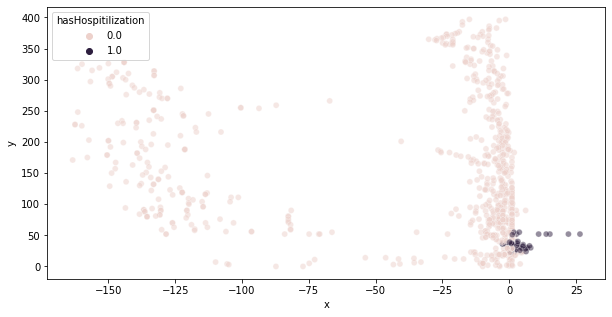

In [285]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='x',y='y',data=g,hue=y_test,alpha=0.5)

<AxesSubplot:xlabel='x', ylabel='y'>

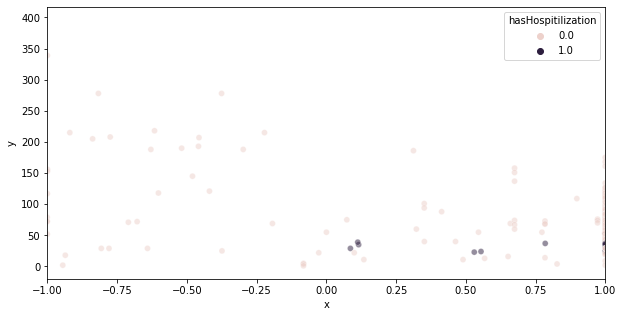

In [286]:
#X-axis limited graph
plt.figure(figsize=(10,5))
plt.xlim(-1, 1)
sns.scatterplot(x='x',y='y',data=g,hue=y_test,alpha=0.5)